# Margin Call Likelihood Analysis

In [1]:
import pandas as pd
import numpy as np
from string import digits
import math
from tqdm import tqdm
import yaml
from functools import reduce

import helpers as hlp

from plotly.offline import init_notebook_mode, iplot
import plotly_utilities as pu

# Allow plotly to operate within the notebook
init_notebook_mode()

%load_ext autoreload
%autoreload 2

In [61]:
for i in range(0,10):
    a = yh.get_yahoo_history("^AXJO", "2000-01-01", "2019-01-01", "weekly")
    print(type(a))

<class 'pandas.core.frame.DataFrame'>


ValueError: From Yahoo: Invalid cookie

In [2]:
conf = yaml.load(open('conf.yaml'))
av_key = conf['alpha_vantage_key']

### Define Session Configuration

In [42]:
# Stocks to examine
symbol = "VTS.AX"
symbols = ['AFI.AX','ARG.AX','MLT.AX','WHF.AX','^AXJO','VTS.AX','VAS.AX']

In [4]:
# Loan Vars
starting_lvr = 0.5
max_lvr = 0.65
buffer = 0.1
step_size = 0.01

In [5]:
# Generate Margin Call Drop Lookup Table
df_mc_triggers = hlp.create_margin_call_range_table(max_lvr, buffer, step_size)
df_mc_triggers.head()

lvr  mc_trigger
0  0.00  100.000000
1  0.01   98.666667
2  0.02   97.333333
3  0.03   96.000000
4  0.04   94.666667

## Get Historical Data & Calculate Margin Calls

In [ ]:
a = hlp.margin_call_samples(symbol = symbol,
                                  time_slice = "weekly",
                                  drawdown_window = 52,
                                  lvr_lookup = df_mc_triggers.copy(deep=True))

In [62]:
mc_results = []
remaining_symbols = []
for symbol in symbols:
    
    try:
        tmp = hlp.margin_call_samples(symbol = symbol,
                                      time_slice = "weekly",
                                      drawdown_window = 52,
                                      lvr_lookup = df_mc_triggers.copy(deep=True))

        mc_results.append(tmp)
        
    except:
        remaining_symbols.append(symbol)
        print("Likely throttled by yahoo")

In [65]:
# Join Historical safe LVR's together
max_safe_lvrs = [(symbols[x], mc_results[x][2] )for x in range(0,len(mc_results))]
max_safe_lvrs = pd.DataFrame(max_safe_lvrs, columns=['Symbol', 'Max Safe LVR'])

max_safe_lvrs.sort_values(by = 'Max Safe LVR')

Symbol  Max Safe LVR
2  MLT.AX      9.657534
3  WHF.AX     33.510638
4   ^AXJO     38.504740
1  ARG.AX     40.891720
0  AFI.AX     44.367909
6  VAS.AX     59.215688
5  VTS.AX     61.638743

In [66]:
# Join margin call frequencies together
mc_counts = [mc_results[x][1] for x in range(0,len(mc_results))]
df_mc_counts = reduce(lambda x, y: pd.merge(x, y, on = ['lvr','mc_trigger']), mc_counts)

# Conver LVR to a percentage
df_mc_counts['lvr'] = df_mc_counts['lvr'] * 100

df_mc_counts.head()

lvr  mc_trigger  AFI_AX_mc_count  ARG_AX_mc_count  MLT_AX_mc_count  \
0  0.0  100.000000                0                0                0   
1  1.0   98.666667                0                0                0   
2  2.0   97.333333                0                0                0   
3  3.0   96.000000                0                0                0   
4  4.0   94.666667                0                0                0   

   WHF_AX_mc_count  ^AXJO_mc_count  VTS_AX_mc_count  VAS_AX_mc_count  
0                0               0                0                0  
1                0               0                0                0  
2                0               0                0                0  
3                0               0                0                0  
4                0               0                0                0

In [69]:
df_mc_counts.columns.tolist()

['lvr',
 'mc_trigger',
 'AFI_AX_mc_count',
 'ARG_AX_mc_count',
 'MLT_AX_mc_count',
 'WHF_AX_mc_count',
 '^AXJO_mc_count',
 'VTS_AX_mc_count',
 'VAS_AX_mc_count']

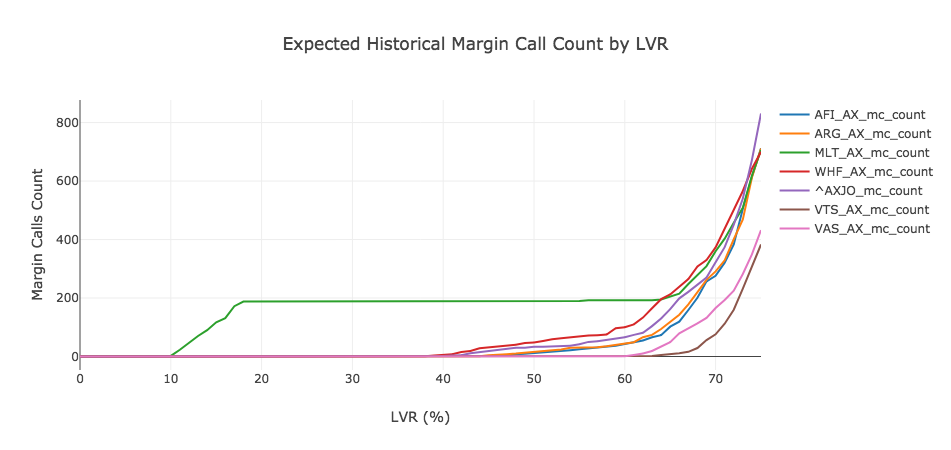

In [70]:
plot_cols = ['AFI_AX_mc_count', 'ARG_AX_mc_count', 'MLT_AX_mc_count',
             'WHF_AX_mc_count', '^AXJO_mc_count', 'VTS_AX_mc_count',
             'VAS_AX_mc_count']


fig = pu.timeseries(df_mc_counts, 
                    x = 'lvr',
                    y = plot_cols,
                    xlabel = 'LVR (%)',
                    ylabel = 'Margin Calls Count',
                    title = 'Expected Historical Margin Call Count by LVR'
                   )

iplot(fig)

Clearly something is up with Milton Corp. It's WAYYYY off compared to the rest.

### Join All EOD Data into a Single DF

In [72]:
eod_list = [mc_results[x][0] for x in range(0,len(mc_results))]
eod_df = pd.concat(eod_list, axis=0)

# eod_df.close.replace(0,np.nan, inplace=True)


eod_df.head()

Date   Open  High   Low  Close  Adj Close     Volume  symbol  \
0 2000-12-31  2.970  2.97  2.54   2.97       2.97   871400.0  AFI.AX   
1 2001-01-07  2.550  2.97  2.52   2.97       2.97  1510142.0  AFI.AX   
2 2001-01-14  2.580  2.97  2.54   2.97       2.97  1549650.0  AFI.AX   
3 2001-01-21  2.550  2.97  2.55   2.97       2.97  1009314.0  AFI.AX   
4 2001-01-28  2.582  3.04  2.55   3.04       3.04  1241811.0  AFI.AX   

   market_drawdown  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

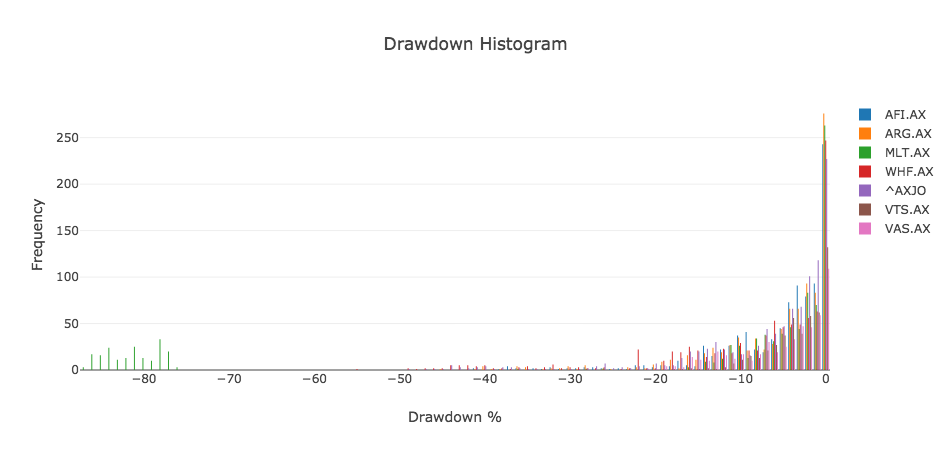

In [73]:
# Drawdown Distributions
# plot_cols = ['ASX:AFI','ASX:ARG','ASX:MLT','ASX:WHF','ASX:XJO','ASX:VTS','ASX:VAS']

fig = pu.histogram(df = eod_df,
                   values='market_drawdown',
                   shape='long',
                   key_col = 'symbol',
#                    keys = 'ASX:MLT',
                   keys = symbols,
                   xlabel = "Drawdown %",
                   ylabel = "Frequency",
                   title = "Drawdown Histogram")
iplot(fig)

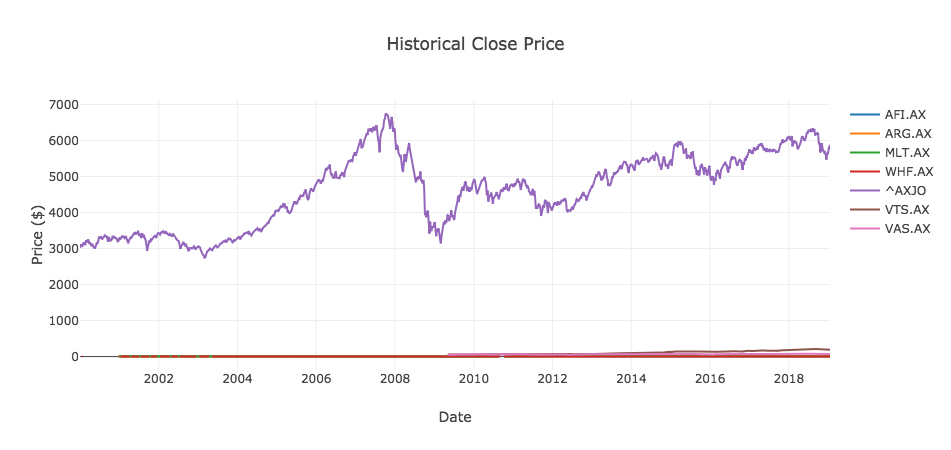

In [80]:
# Time Series
fig = pu.timeseries(df = eod_df,
                    x = 'Date',
                    y = 'Close',
                    title = 'Historical Close Price',
                    xlabel = 'Date',
                    ylabel = 'Price ($)',
                    shape = 'long',
                    key_col = 'symbol',
                    keys = symbols)

iplot(fig)

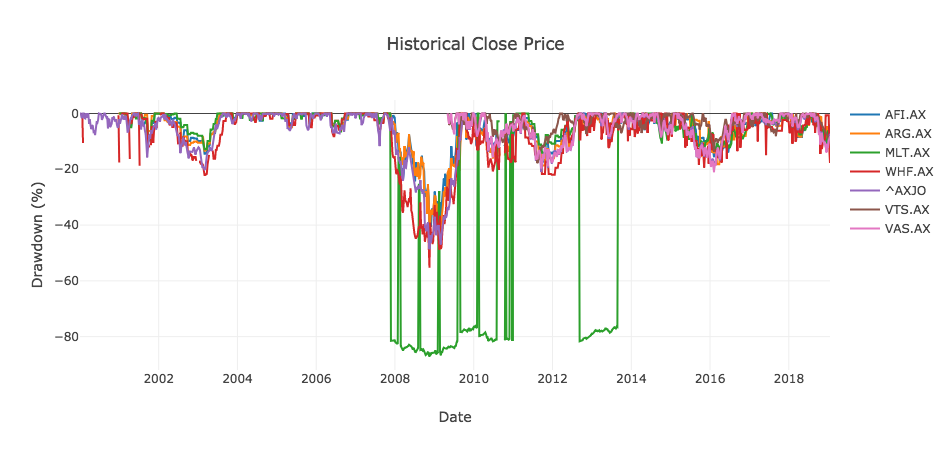

In [81]:
# Drawdown Time Series
fig = pu.timeseries(df = eod_df,
                    x = 'Date',
                    y = 'market_drawdown',
                    title = 'Historical Close Price',
                    xlabel = 'Date',
                    ylabel = 'Drawdown (%)',
                    shape = 'long',
                    key_col = 'symbol',
                    keys = symbols)

iplot(fig)

# Things to fix
1. Why is a bunch of data missing from 2010-2019?
2. What's up with the weird straight lines in the plots?
3. Why do some of the timeseries appear discontinuous?

In [ ]:
eod_df[eod_df['symbol'] = 'ASX:WHF']

# Misc Junk

In [ ]:
margin_call_samples("VAS.AX", 52, )

In [423]:
# Get historical price data
df_eod = get_historical_data(alpha_vantage_key, time_slice='weekly', symbol=symbol)

# # Calculate LVR over time
# df_margin_loan = calc_lvr(df = df_eod,
#                           initial_investment = 50000,
#                           initial_lvr = starting_lvr)

# Calculate Drawdown
window_size = 52 # 1 year
df_margin_loan = calc_drawdown(df_eod, price_col = 'close', window_size = window_size)

In [374]:
df_margin_loan.head()

date   open   high    low  close  volume  market_drawdown
0 2009-05-22  60.30  60.30  57.82  57.82  1775.0         0.000000
1 2009-05-29  57.25  58.48  57.25  58.12   481.0         0.000000
2 2009-06-05  58.12  59.27  58.00  59.12  3601.0         0.000000
3 2009-06-12  59.12  59.65  58.57  58.57   453.0        -0.930311
4 2009-06-19  59.05  59.06  57.51  57.51  1214.0        -2.723275

In [436]:
# For every possible lvr, calculate drawdown required to trigger a margin call
# Assuming max_lvr of 65% & buffer of 10%
max_lvr = 0.65
buffer = 0.1
step_size = 0.05
lvr_range = np.arange(0, max_lvr+buffer+step_size, step_size)

df_mc_triggers = pd.DataFrame({
    "lvr": lvr_range,
    "mc_trigger": [calc_margin_call_drop(x, max_lvr, buffer) for x in lvr_range]
})

In [442]:
df_mc_triggers.lvr.max()

0.75

In [437]:
mc_counts = list()

for row, col in df_mc_triggers.iterrows():
    # Identify drawdowns that would have caused a margin call
    margin_calls = df_margin_loan['market_drawdown'].apply(
        lambda x: 1 if abs(x) > col['mc_trigger'] and x < 1 else 0)

    # Count instances
    counts = margin_calls.value_counts()
    mc_count = counts[1] if(len(counts)>1) else 0

    mc_counts.append(mc_count)
    
df_mc_triggers['margin_calls'] = mc_counts
df_mc_triggers

symbol   lvr  mc_trigger  margin_calls
0     VTS  0.00  100.000000             0
1     VTS  0.05   93.333333             0
2     VTS  0.10   86.666667             0
3     VTS  0.15   80.000000             0
4     VTS  0.20   73.333333             0
5     VTS  0.25   66.666667             0
6     VTS  0.30   60.000000             0
7     VTS  0.35   53.333333             0
8     VTS  0.40   46.666667             0
9     VTS  0.45   40.000000             0
10    VTS  0.50   33.333333             0
11    VTS  0.55   26.666667             0
12    VTS  0.60   20.000000             0
13    VTS  0.65   13.333333             7
14    VTS  0.70    6.666667            72
15    VTS  0.75    0.000000           363

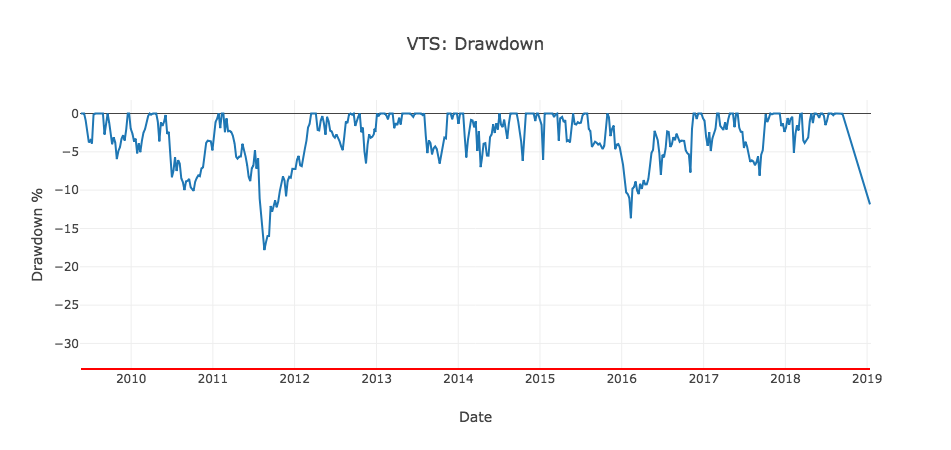

In [340]:
title = '{}: Drawdown'.format(symbol)
fig = pu.timeseries(df_margin_loan[(df_margin_loan.market_drawdown > -100)],
                    x='date',
                    y=['market_drawdown'],
                    title=title,
                    ylabel = 'Drawdown %', 
                    xlabel='Date')

margin_call_trigger = {
    'type': 'line',
    'x0': df_margin_loan['date'].min(),
    'x1': df_margin_loan['date'].max(),
    'y0': mc_drop_trigger,
    'y1': mc_drop_trigger,
    'line': {
        'color': 'red',
        'width': 2
    }
}


fig.layout['shapes'].append(margin_call_trigger)

iplot(fig)

In [375]:
# Calculate fall required to trigger a margin call
mc_drop_trigger = -1 * calc_margin_call_drop(starting_lvr, max_lvr, buffer)
mc_drop_trigger

-33.333333333333336

In [341]:
min_margin_call_events = df_margin_loan[df_margin_loan.market_drawdown > -100].margin_called.diff().apply(lambda x: 1 if x==1 else 0).sum()
print("{}: LVR of {}% resulted in at least {} drops over {}% triggering a margin call".format(symbol,
                                                                                              round(starting_lvr*100,2),
                                                                                              min_margin_call_events,
                                                                                              round(mc_drop_trigger*-1, 2)))

max_lvr_to_avoid_margin_call = calc_max_safe_lvr(df_margin_loan[df_margin_loan.market_drawdown > -100].market_drawdown.min(), max_lvr, buffer)
print("{}: Max LVR of {}% historically required to avoid a margin call".format(symbol, round(max_lvr_to_avoid_margin_call,1)))

VTS: LVR of 50.0% resulted in at least 0 drops over 33.33% triggering a margin call
VTS: Max LVR of 61.6% historically required to avoid a margin call
